# Clone github repository

In [ ]:
%rm -rf 'dl_with_torch'
!git clone https://github.com/sadhana1058/dl_with_torch.git

Cloning into 'dl_with_torch'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 68 (delta 14), reused 47 (delta 6), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [ ]:
%cd /content/dl_with_torch/

/content/dl_with_torch


In [ ]:
import sys
sys.path.append('/dl_with_torch/')

!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-uroih_9e
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-uroih_9e
     |████████████████████████████████| 47.6 MB 21.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=104716 sha256=42a9e2df5d3b69b9e3470faea6c75626a0c9b18bab3ec49d7548da898ed164ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-z9wdkoot/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install torch-lr-finder

In [ ]:
! git clone https://github.com/seshuad/IMagenet
# ! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.


# Libraries 

In [ ]:
from models.custom_resnet import CustomResnet
from src.GradCAM.visualization import VisualizeCam
from src.accuracy import *
from src.data_augmentation import *
from src.plot_train_test_acc_loss import *
from src.misclassification import *
from utils.utils import *
from src.custom_dataset_tiny_imagenet import *
# from utils import util
from main import *

In [ ]:
import torch
import os

print(os.getcwd())

/content/dl_with_torch


In [ ]:
!pip install torchsummary
!pip install -U albumentations

from torchsummary import summary
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
%matplotlib inline

# CUDA Availablity

In [ ]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Model Summary

In [ ]:
from models.resnet import ResNet18

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model,  input_size=(3, 64, 64))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
         GroupNorm-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
         GroupNorm-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
         GroupNorm-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
         GroupNorm-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
        GroupNorm-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
        GroupNorm-14          [-1,

# Train and testloaders

In [ ]:
channel_means = (0.49142,0.48222,0.44652)
channel_stdevs = (0.2023, 0.1994, 0.2010)

def getTrainTransforms():
    train_transforms = A.Compose(
    [ 
      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
      A.RandomCrop(height=64, width=64, always_apply=True),
      A.HorizontalFlip(p = 0.7),
      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
      A.Normalize(mean=channel_means, std=channel_stdevs),
      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7),                                                                  
      ToTensorV2()     
    ]
)
    return train_transforms

def getTestTransforms():
    test_transforms = A.Compose([
         A.Normalize(mean=channel_means, std=channel_stdevs),
         ToTensorV2(),
         ])

    return test_transforms

In [ ]:
train_transforms = getTrainTransforms()
test_transforms = getTestTransforms()
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transforms,train_transforms = train_transforms)

Images already downloaded...


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:695: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Loading Train Folder:   0%|          | 0/200 [00:00<?, ?it/s]

Loading Test Folder:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
trainset =train_dataset
testset= test_dataset

In [ ]:
# import opendatasets as od
import os
from random import randint
import urllib
import zipfile


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2021-12-13 13:27:54--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  51.4MB/s    in 5.1s    

2021-12-13 13:27:59 (46.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
class args():
    def __init__(self,device = 'cpu' ,use_cuda = False) -> None:
        self.batch_size = 512
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if self.use_cuda else {}

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=args().batch_size,shuffle=True, **args().kwargs)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=args().batch_size,shuffle=True, **args().kwargs)

In [ ]:
visualize_augmentations(train_dataset,train_transforms,5 )

# After data augmentation

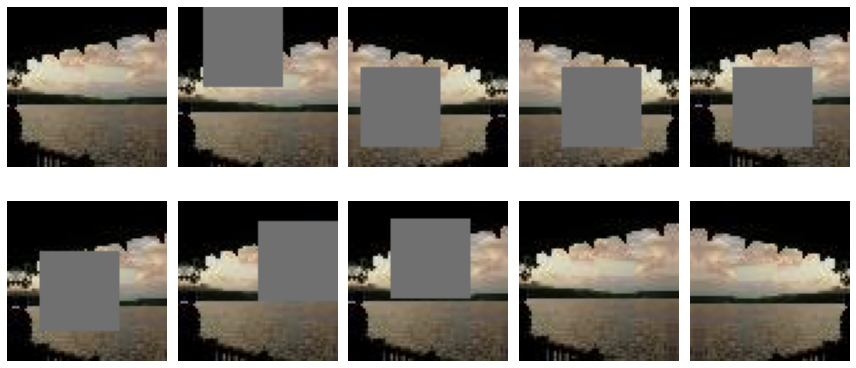

In [ ]:
visualize_data_augmentations(train_dataset,train_transform,5 )

In [ ]:
len(train_dataset), len(test_dataset), 

(77000, 33000)

# Optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=50, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

# Epoch


In [ ]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

learning_rates = []
epochs=30#due to time shortage

max_epoch = 5
lr = 0.01

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.0001) 
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=epochs, steps_per_epoch=len(trainloader), 
                       pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,div_factor=10.0,final_div_factor =10)


In [ ]:
for epoch in range(epochs):
  print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
  train(model, device, trainloader, optimizer, scheduler, criterion, epoch,train_losses,train_accuracy )
  test(model, device, criterion, testloader,test_losses, test_accuracy )
  for param_group in optimizer.param_groups:
    learning_rates.append(param_group['lr']) 

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=4.193744659423828 Batch_id=300 Accuracy=5.55: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 2974/33000 (9.01%)

EPOCH: 2 LR: 0.0038005982053838485


Loss=3.761247158050537 Batch_id=300 Accuracy=13.85: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 5008/33000 (15.18%)

EPOCH: 3 LR: 0.005601196410767697


Loss=3.4212605953216553 Batch_id=300 Accuracy=19.84: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 6542/33000 (19.82%)

EPOCH: 4 LR: 0.007401794616151546


Loss=3.300711154937744 Batch_id=300 Accuracy=24.61: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 7768/33000 (23.54%)

EPOCH: 5 LR: 0.009202392821535395


Loss=3.1839206218719482 Batch_id=300 Accuracy=28.59: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9358/33000 (28.36%)

EPOCH: 6 LR: 0.011002991026919245


Loss=2.993387460708618 Batch_id=300 Accuracy=31.91: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 8913/33000 (27.01%)

EPOCH: 7 LR: 0.012803589232303092


Loss=2.7723305225372314 Batch_id=300 Accuracy=34.53: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 9544/33000 (28.92%)

EPOCH: 8 LR: 0.01460418743768694


Loss=2.484865188598633 Batch_id=300 Accuracy=36.93: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10183/33000 (30.86%)

EPOCH: 9 LR: 0.01640478564307079


Loss=2.4606924057006836 Batch_id=300 Accuracy=39.35: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11199/33000 (33.94%)

EPOCH: 10 LR: 0.01820538384845464


Loss=2.6643524169921875 Batch_id=300 Accuracy=41.15: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 11896/33000 (36.05%)

EPOCH: 11 LR: 0.01999671096345515


Loss=2.326511859893799 Batch_id=300 Accuracy=43.18: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12468/33000 (37.78%)

EPOCH: 12 LR: 0.01900671096345515


Loss=2.2425622940063477 Batch_id=300 Accuracy=45.30: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 12887/33000 (39.05%)

EPOCH: 13 LR: 0.01801671096345515


Loss=2.0580687522888184 Batch_id=300 Accuracy=47.00: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 13103/33000 (39.71%)

EPOCH: 14 LR: 0.01702671096345515


Loss=2.1617488861083984 Batch_id=300 Accuracy=49.09: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 14540/33000 (44.06%)

EPOCH: 15 LR: 0.01603671096345515


Loss=2.0399906635284424 Batch_id=300 Accuracy=50.62: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 14351/33000 (43.49%)

EPOCH: 16 LR: 0.01504671096345515


Loss=1.9319827556610107 Batch_id=300 Accuracy=52.05: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 14944/33000 (45.28%)

EPOCH: 17 LR: 0.014056710963455149


Loss=1.6608678102493286 Batch_id=300 Accuracy=53.70: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 14892/33000 (45.13%)

EPOCH: 18 LR: 0.01306671096345515


Loss=1.881971001625061 Batch_id=300 Accuracy=55.25: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 14973/33000 (45.37%)

EPOCH: 19 LR: 0.012076710963455148


Loss=1.6770224571228027 Batch_id=300 Accuracy=56.84: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 15783/33000 (47.83%)

EPOCH: 20 LR: 0.011086710963455149


Loss=1.6732585430145264 Batch_id=300 Accuracy=58.30: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16115/33000 (48.83%)

EPOCH: 21 LR: 0.010096710963455147


Loss=1.6595666408538818 Batch_id=300 Accuracy=59.64: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15705/33000 (47.59%)

EPOCH: 22 LR: 0.00910671096345515


Loss=1.4669309854507446 Batch_id=300 Accuracy=61.55: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16095/33000 (48.77%)

EPOCH: 23 LR: 0.008116710963455148


Loss=1.6893534660339355 Batch_id=300 Accuracy=62.91: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 16108/33000 (48.81%)

EPOCH: 24 LR: 0.00712671096345515


Loss=1.480400800704956 Batch_id=300 Accuracy=64.75: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16445/33000 (49.83%)

EPOCH: 25 LR: 0.006136710963455149


Loss=1.2107820510864258 Batch_id=300 Accuracy=66.07: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 17323/33000 (52.49%)

EPOCH: 26 LR: 0.005146710963455148


Loss=1.2747420072555542 Batch_id=300 Accuracy=67.97: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 17377/33000 (52.66%)

EPOCH: 27 LR: 0.00415671096345515


Loss=1.1309386491775513 Batch_id=300 Accuracy=70.35: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 17878/33000 (54.18%)

EPOCH: 28 LR: 0.0031667109634551487


Loss=1.0643219947814941 Batch_id=300 Accuracy=72.68: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 18242/33000 (55.28%)

EPOCH: 29 LR: 0.002176710963455151


Loss=1.030601143836975 Batch_id=300 Accuracy=75.11: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 18565/33000 (56.26%)

EPOCH: 30 LR: 0.0011867109634551495


Loss=0.9878716468811035 Batch_id=300 Accuracy=77.83: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]



Test set: Average loss: 0.0070, Accuracy: 18991/33000 (57.55%)



#graph

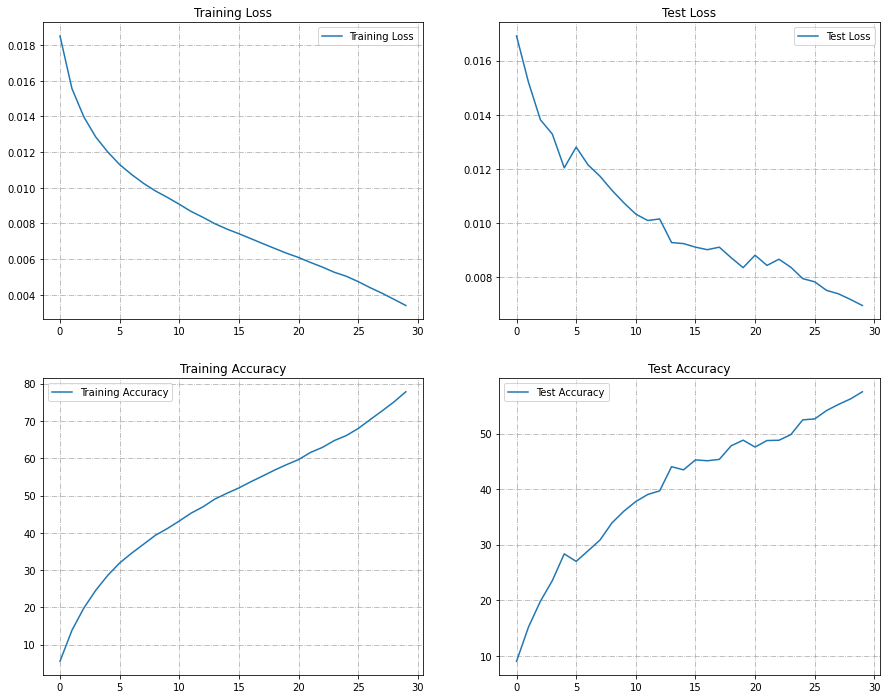

In [ ]:
plot_test_train_loss_accurracy(train_losses, train_accuracy, test_losses, test_accuracy)

No handles with labels found to put in legend.


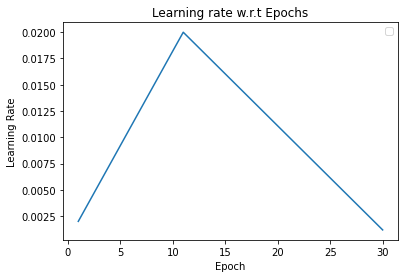

In [ ]:
plt.plot(learning_rates, '-D')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate over Training-Epochs',fontsize=15)